## Settings


In [1]:
import os

# Change the execution path to the desired directory
os.chdir('..')

# Verify the new execution path
print(os.getcwd())

c:\Users\Hoang\Code\ML\ir_project


In [2]:
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import torch
import pandas as pd
import numpy as np
from torchsummary import summary

from tqdm import tqdm
from src.model import FeatureExtractor
from src.utils import (
    read_index,
    load_dict,
    read_index,
    write_index,
    create_index,
    deserialize_str,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
data_path = Path("landmark_images")
annotation_path = Path("annotation")

## Dataset


In [5]:
not_ground_truth = load_dict(file_path=str(annotation_path / "anti_gnd.pkl"))

query = load_dict(file_path=str(annotation_path / "query.pkl"))

In [6]:
folder_names = os.listdir(data_path)

len(folder_names)

47

In [7]:
imlist = dict()

for key in folder_names:
    imlist[key] = []
    for file in (data_path / key).iterdir():
        filename = file.name

        if key == "unknown":
            imlist[key].append(filename)
            continue

        file_idx = int(file.stem)
        # select only jpg files not in query set
        if file.suffix == ".jpg" and file_idx not in query[key]:
            imlist[key].append(filename)

In [8]:
ground_truth = dict()

for key in folder_names:
    ground_truth[key] = []
    if key == "unknown":
        continue
    for file in (data_path / key).iterdir():
        filename = file.name

        file_idx = int(file.stem)
        # select only jpg files in ground truth set
        if (
            file.suffix == ".jpg"
            and file_idx not in not_ground_truth[key]
            and file_idx not in query[key]
        ):
            ground_truth[key].append(filename)

In [9]:
query_loc = []

for landmark in query.keys():
    for file in query[landmark]:
        image_path = data_path / landmark / f"{file}.jpg"
        query_loc.append(image_path)


def path_to_landmark(path):
    return path.parent.name


def get_query(query_idx):
    img_path = query_loc[query_idx]
    img = Image.open(img_path)
    landmark = path_to_landmark(img_path)
    return img, landmark

In [10]:
def extract_correct_ans(ans_list, query_landmark):
    correct_ans = []
    gnd_list = ground_truth[query_landmark]
    for ans in ans_list:
        _, ans_landmark, filename = ans.split("\\")

        if ans_landmark == query_landmark and filename in gnd_list:
            correct_ans.append(ans)
    return correct_ans

In [11]:
class Vietnam46AttrDataset(Dataset):
    def __init__(self, imlist, transform=None):
        self.imlist = imlist
        self.landmarks = list(imlist.keys())
        self.lengths = [len(value) for value in imlist.values()]
        self.image_loc = self._load_data()
        self.transform = transform

    def __len__(self):
        return sum(self.lengths)

    def _get_filepath(self, idx):
        return self.image_loc[idx]

    def __getitem__(self, index):
        img_path = self._get_filepath(index)
        img = Image.open(img_path)
        img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)
        return img, img_path

    def _load_data(self):
        images_loc = []
        for landmark in self.landmarks:
            for filename in self.imlist[landmark]:
                image_path = os.path.join(data_path, landmark, filename)
                images_loc.append(image_path)
        return images_loc

In [12]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [13]:
ds = Vietnam46AttrDataset(imlist, transform=transform)
sampler = SequentialSampler(ds)
dl = DataLoader(ds, batch_size=64, sampler=sampler)


len(ds), len(dl)

(8846, 139)

In [14]:
batch, paths = next(iter(dl))

batch.shape, len(paths)

(torch.Size([64, 3, 224, 224]), 64)

# Model


In [15]:
extractor = FeatureExtractor(model_name="resnet101").to(device)

In [16]:
index = create_index(extractor.feature_size, metrics="IP")

In [17]:
import time

start = time.time()

with tqdm(total=len(dl), desc="Extracting features") as pbar:
    for batch, _ in dl:
        batch = batch.to(device)


        features = extractor(batch)


        index.add(features)


        pbar.update(1)
end = time.time()

total_time = end - start



write_index(index, "index/Vietnam46Attr.resnet101_IP.bin")

Extracting features: 100%|██████████| 139/139 [01:07<00:00,  2.07it/s]


In [18]:
index = read_index("index/Vietnam46Attr.resnet101_IP.bin")

print(f"Number of vectors in index: {index.ntotal}")

Number of vectors in index: 8846


# Retrieval


In [19]:
def retrieve(query_img, k, index=index):
    img = transform(query_img)
    img = img.unsqueeze(0).to(device)

    feat = extractor(img)
    distance, indices = index.search(feat, k)

    return indices[0].tolist(), distance[0].tolist()

In [20]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [21]:
view_ds = Vietnam46AttrDataset(imlist, transform=None)

(<matplotlib.image.AxesImage at 0x19817950890>,
 'japanese_covered_bridge_in_quang_nam')

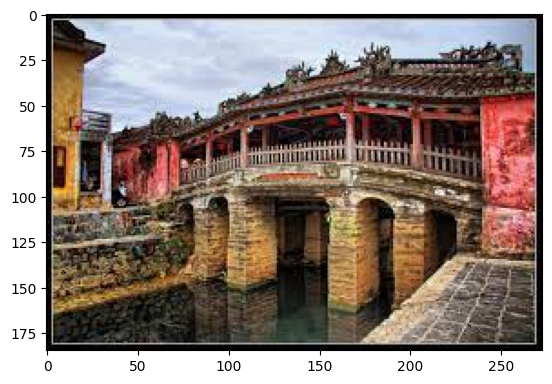

In [22]:
rand_idx = np.random.randint(0, len(query_loc))
img, lm = get_query( rand_idx)


plt.imshow(img), lm

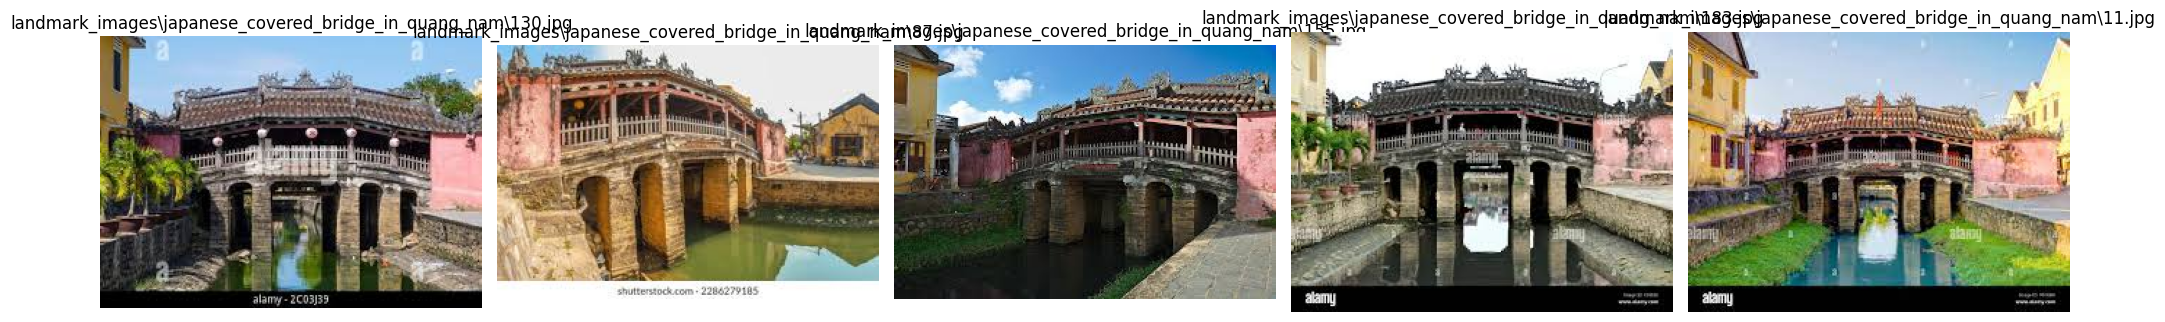

In [23]:
idx, dst = retrieve(img, 5)

images = []
titles = []

cols = 5
rows = 1

for i in idx:
    images.append(view_ds[i][0])
    titles.append(view_ds[i][1])

plot_images(images, titles, rows, cols)

# Evaluation


In [24]:
answer_list = []
qlandmark_list = []

for i in tqdm(range(len(query_loc))):
    img, query_landmark = get_query(i)
    gnd_size = len(ground_truth[query_landmark])
    idx, dst = retrieve(img, gnd_size)

    ans = [ds._get_filepath(i) for i in idx]
    answer_list.append(ans)
    qlandmark_list.append(query_landmark)

100%|██████████| 230/230 [00:04<00:00, 56.60it/s]


## Recall

In [25]:
def recallk(ans_list, query_landmark_list, k):
    recall_scores = []
    recall_by_landmark = dict()
    for ans, landmark in zip(ans_list, query_landmark_list):
        if len(ans) > 0:
            corr_ans = extract_correct_ans(ans[:k], landmark)
            recall_score = len(corr_ans) / len(ground_truth[landmark])
            recall_scores.append(recall_score)
            if landmark not in recall_by_landmark:
                recall_by_landmark[landmark] = [recall_score]
            else:
                recall_by_landmark[landmark].append(recall_score)

    for landmark in recall_by_landmark.keys():
        recall_by_landmark[landmark] = sum(recall_by_landmark[landmark]) / len(
            recall_by_landmark[landmark]
        )

    return sum(recall_scores) / len(ans_list), recall_by_landmark

In [26]:
k = 5
scores, recall_by_landmark = recallk(answer_list, qlandmark_list, k)

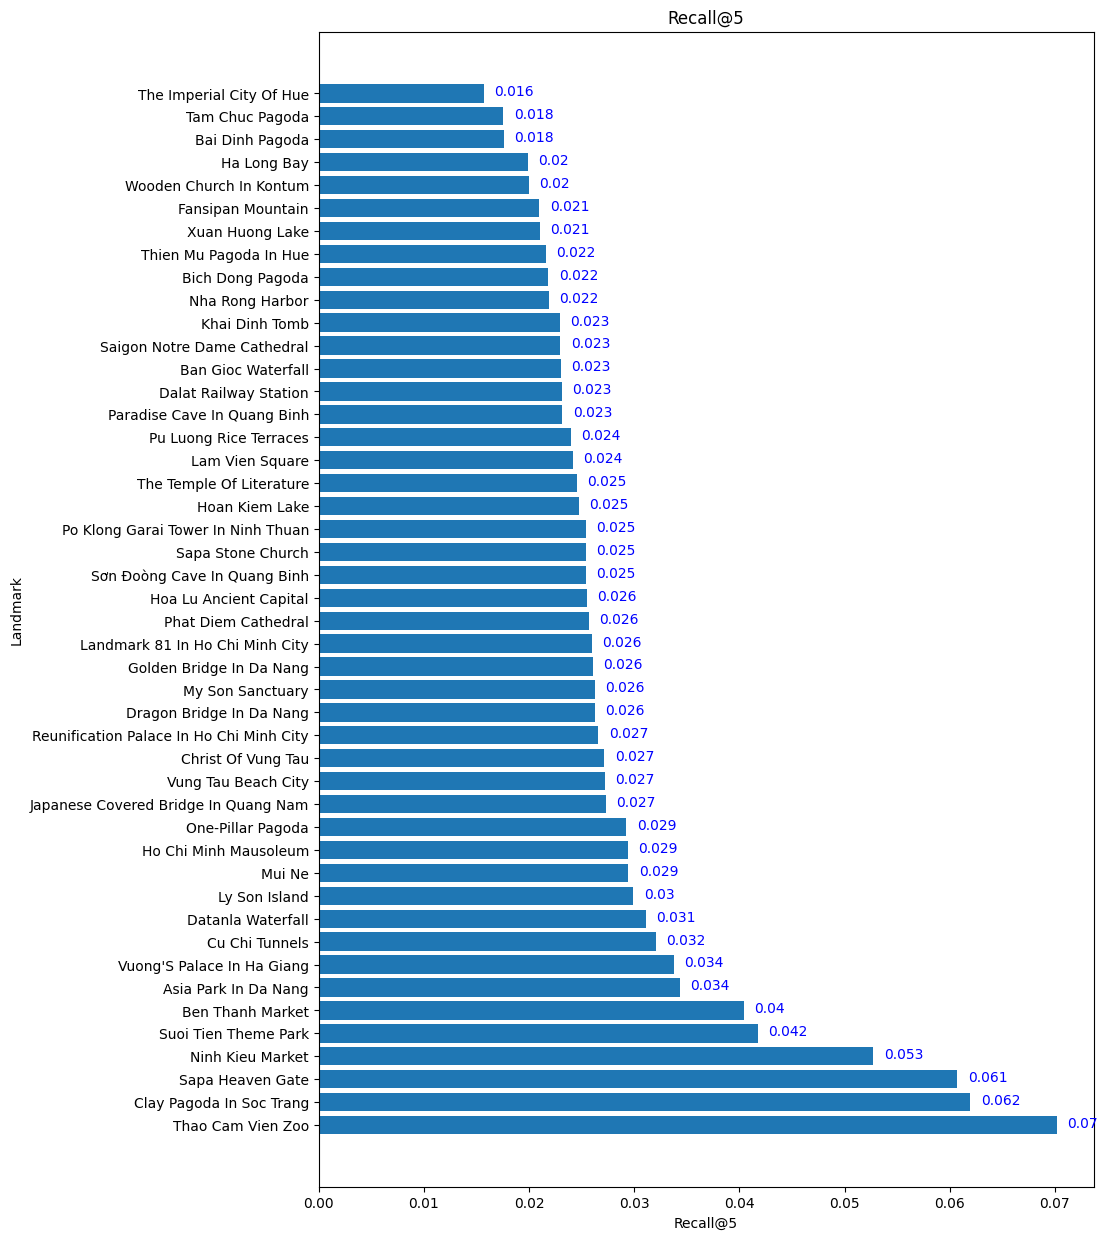

In [27]:
recall_by_landmark = dict(
    sorted(recall_by_landmark.items(), key=lambda x: x[1], reverse=True)
)

folder_names = [deserialize_str(lm) for lm in list(recall_by_landmark.keys())]
scores = list(recall_by_landmark.values())

plt.figure(figsize=(10, 15))
plt.barh(folder_names, scores)
plt.xlabel(f"Recall@{k}")
plt.ylabel("Landmark")
plt.title(f"Recall@{k}")

for i, v in enumerate(scores):
    plt.text(v + 0.001, i - 0.1, str(round(v, 3)), color="blue")

plt.show()

In [28]:
k_list = [1, 3, 5, 10, 20, 50]
recall_scores = [recallk(answer_list, qlandmark_list, k)[0] for k in k_list]
data = {"Score": recall_scores}

df = pd.DataFrame(data, index=[f"recall@{k}" for k in k_list])

df.round(4)

,Score
recall@1,0.0065
recall@3,0.0185
recall@5,0.0289
recall@10,0.0531
recall@20,0.0946
recall@50,0.1900


## R-precision

In [29]:
def compute_r_precision(ans, query_landmark):
    correct_ans = extract_correct_ans(ans, query_landmark)
    return len(correct_ans) / len(ground_truth[query_landmark])

In [30]:
r_precision_scores = []

r_precision_by_landmark = dict()
for ans, landmark in zip(answer_list, qlandmark_list):
    score = compute_r_precision(ans, landmark)
    if len(ans) > 0:
        r_precision_scores.append(score)
    if landmark not in r_precision_by_landmark:
        r_precision_by_landmark[landmark] = [score]
    else:
        r_precision_by_landmark[landmark].append(score)

for landmark in r_precision_by_landmark.keys():
    r_precision_by_landmark[landmark] = np.array(
        r_precision_by_landmark[landmark]
    ).mean()

r_precision_scores = np.array(r_precision_scores)
print(f"Avg R-precision: {r_precision_scores.mean():.4f}")

Avg R-precision: 0.3759


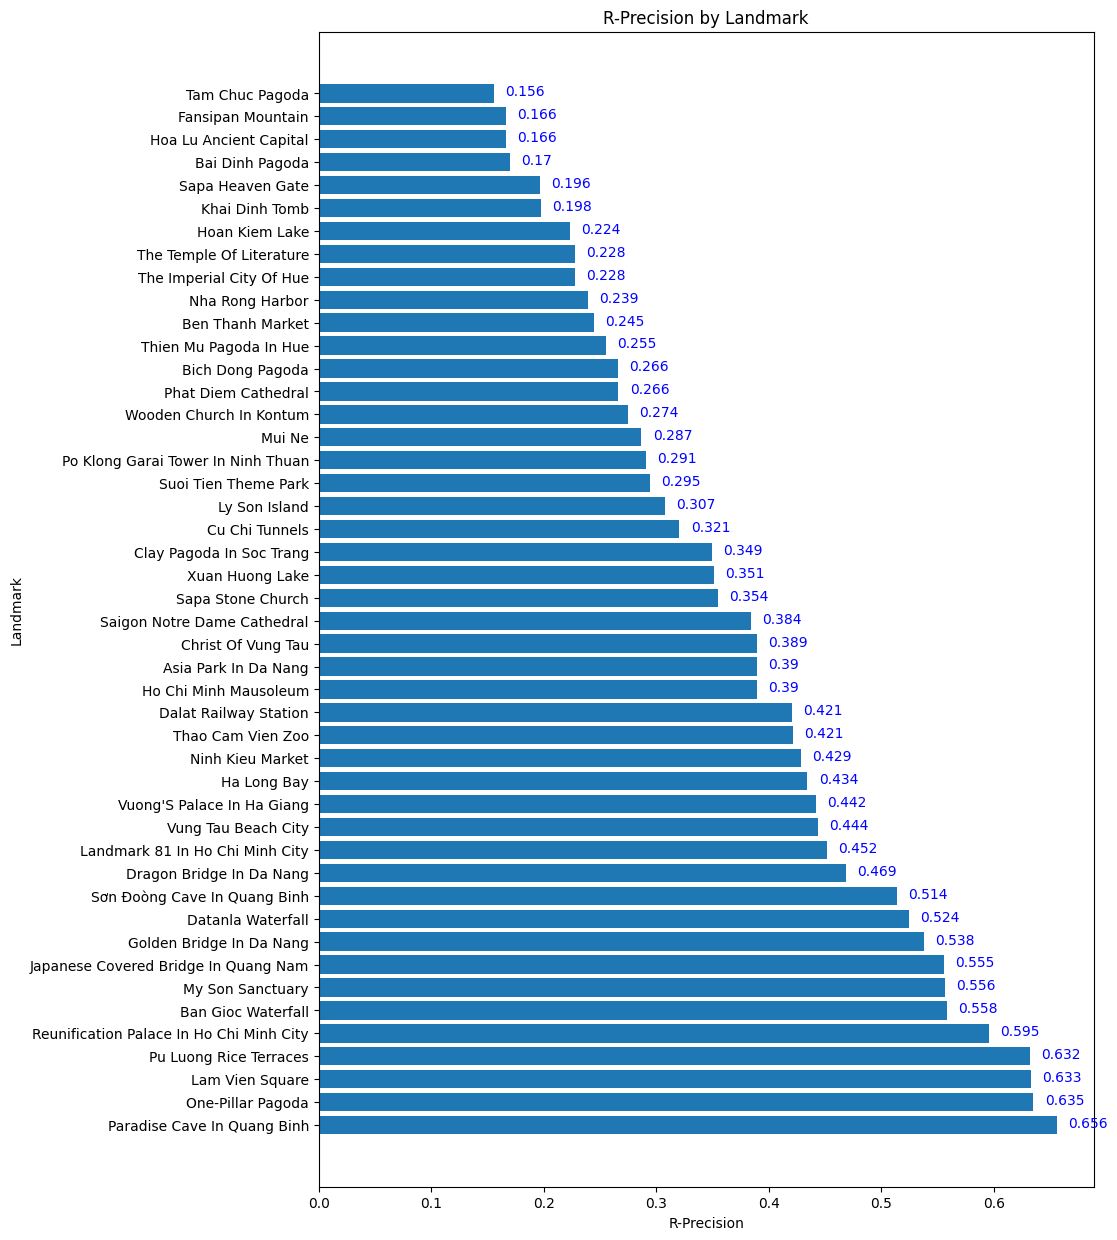

In [31]:
r_precision_by_landmark = dict(
    sorted(r_precision_by_landmark.items(), key=lambda x: x[1], reverse=True)
)

folder_names = [deserialize_str(lm) for lm in list(r_precision_by_landmark.keys())]
scores = list(r_precision_by_landmark.values())

plt.figure(figsize=(10, 15))
plt.barh(folder_names, scores)
plt.xlabel("R-Precision")
plt.ylabel("Landmark")
plt.title("R-Precision by Landmark")

for i, v in enumerate(scores):
    plt.text(v + 0.01, i - 0.1, str(round(v, 3)), color="blue")

plt.show()

## mAP

In [32]:
def ap(ans, query_landmark):
    precision_scores = []
    cor_cases = 0
    for idx, a in enumerate(ans):
        _, ans_landmark, filename = a.split("\\")

        if ans_landmark == query_landmark and filename in ground_truth[query_landmark]:
            cor_cases += 1
            precision_scores.append(cor_cases / (idx + 1))

    return sum(precision_scores) / len(ans)


def mapk(ans_list, query_landmark_list, k):
    ap_scores = []
    ap_by_landmark = dict()
    for ans, landmark in zip(ans_list, query_landmark_list):
        if len(ans) > 0:
            ap_score = ap(ans[:k], landmark)
            ap_scores.append(ap_score)
            if landmark not in ap_by_landmark:
                ap_by_landmark[landmark] = [ap_score]
            else:
                ap_by_landmark[landmark].append(ap_score)

    for landmark in ap_by_landmark.keys():
        ap_by_landmark[landmark] = sum(ap_by_landmark[landmark]) / len(
            ap_by_landmark[landmark]
        )

    return sum(ap_scores) / len(ap_scores), ap_by_landmark

In [33]:
k = 5
scores, ap_by_landmark = mapk(answer_list, qlandmark_list, k)

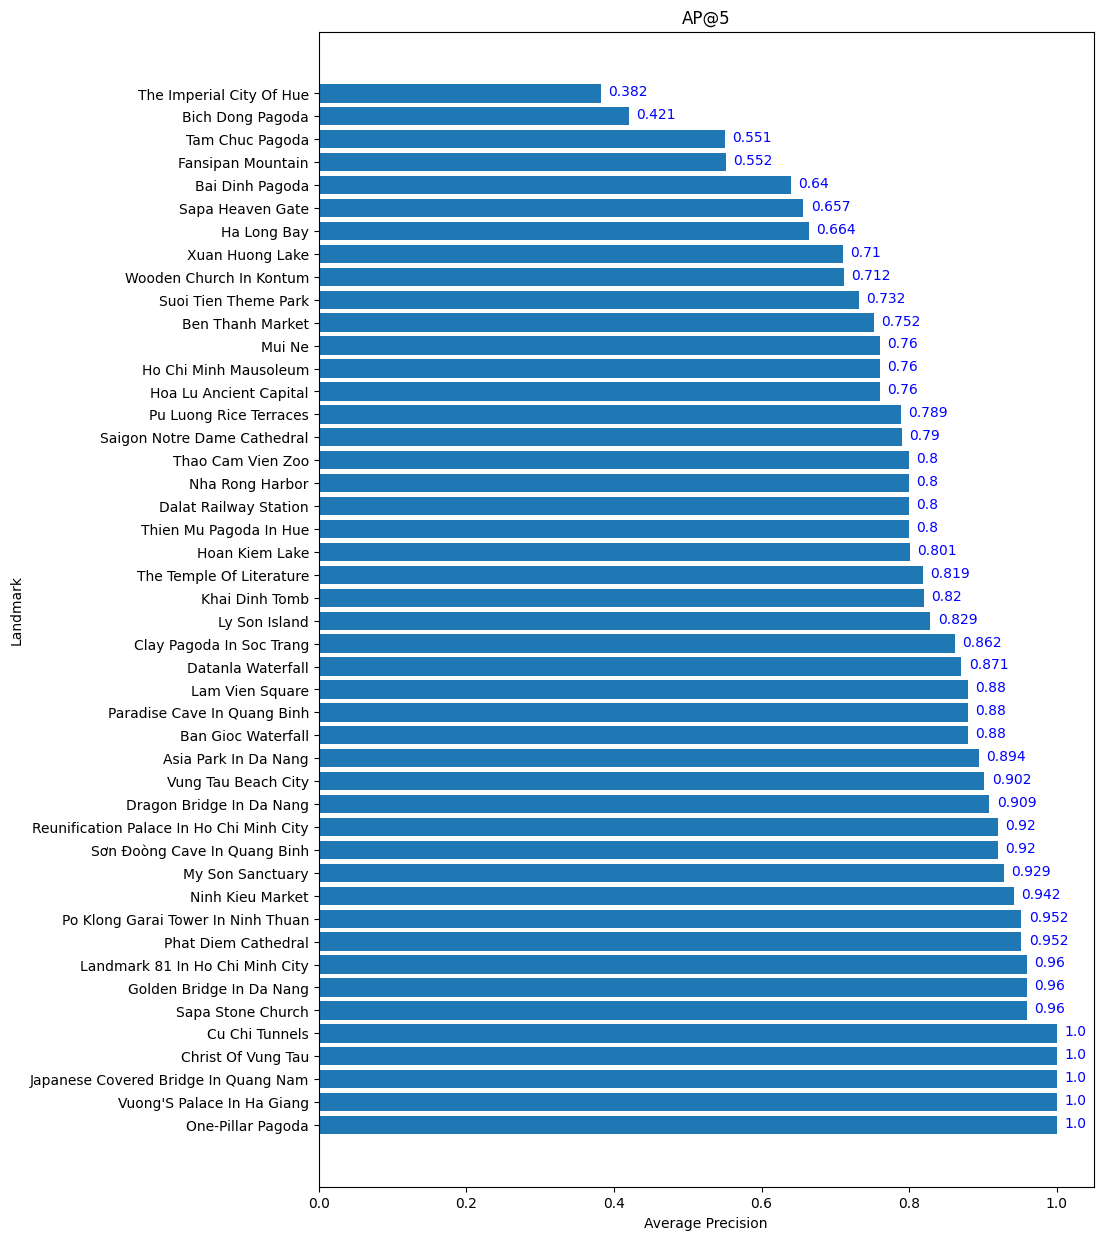

In [34]:
ap_by_landmark = dict(sorted(ap_by_landmark.items(), key=lambda x: x[1], reverse=True))

folder_names = [deserialize_str(lm) for lm in list(ap_by_landmark.keys())]
scores = list(ap_by_landmark.values())

plt.figure(figsize=(10, 15))
plt.barh(folder_names, scores)
plt.xlabel("Average Precision")
plt.ylabel("Landmark")
plt.title(f"AP@{k}")

for i, v in enumerate(scores):
    plt.text(v + 0.01, i - 0.1, str(round(v, 3)), color="blue")

plt.show()

In [35]:
k_list = [1, 3, 5, 10, 20, 50]
mapk_scores = [mapk(answer_list, qlandmark_list, k)[0] for k in k_list]
data = {"Score": mapk_scores}

df = pd.DataFrame(data, index=[f"mAP@{k}" for k in k_list])

df.round(4)

,Score
mAP@1,0.9261
mAP@3,0.8734
mAP@5,0.8189
mAP@10,0.7420
mAP@20,0.6444
mAP@50,0.4948


## Precision

In [36]:
def precisionk(ans_list, query_landmark_list, k):
    precision_scores = []
    precision_by_landmark = dict()
    for ans, landmark in zip(ans_list, query_landmark_list):
        if len(ans) > 0:
            corr_ans = extract_correct_ans(ans[:k], landmark)
            precision_score = len(corr_ans) / k
            precision_scores.append(precision_score)
            if landmark not in precision_by_landmark:
                precision_by_landmark[landmark] = [precision_score]
            else:
                precision_by_landmark[landmark].append(precision_score)

    for landmark in precision_by_landmark.keys():
        precision_by_landmark[landmark] = sum(precision_by_landmark[landmark]) / len(
            precision_by_landmark[landmark]
        )

    return sum(precision_scores) / len(precision_scores), precision_by_landmark

In [37]:
k = 5
scores, prec_by_landmark = precisionk(answer_list, qlandmark_list, k)

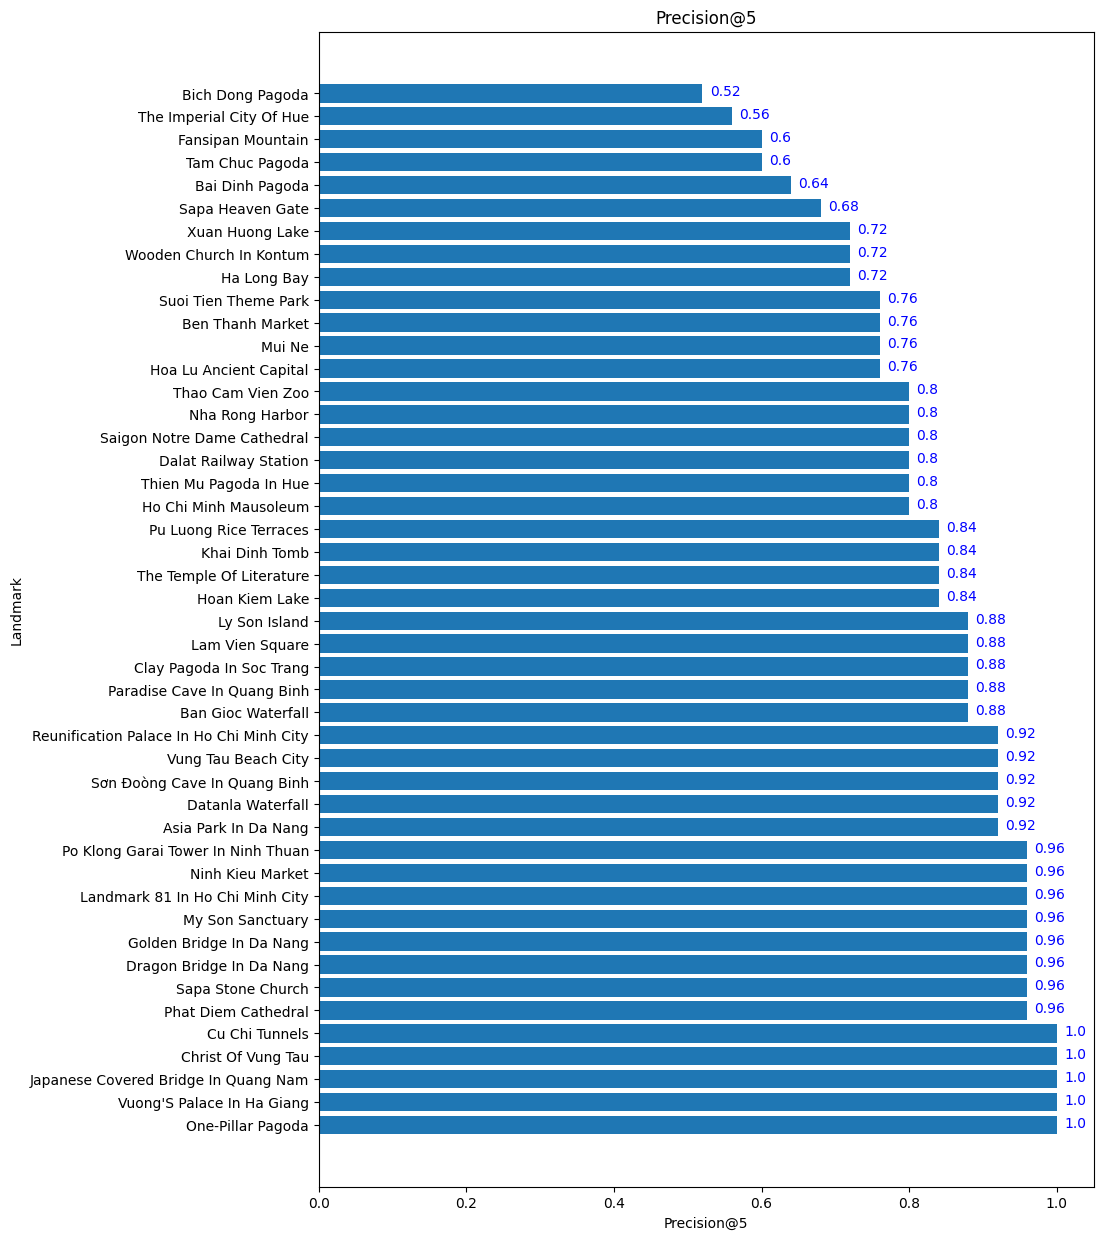

In [38]:
prec_by_landmark = dict(
    sorted(prec_by_landmark.items(), key=lambda x: x[1], reverse=True)
)


folder_names = [deserialize_str(lm) for lm in list(prec_by_landmark.keys())]
scores = list(prec_by_landmark.values())

plt.figure(figsize=(10, 15))
plt.barh(folder_names, scores)
plt.xlabel(f"Precision@{k}")
plt.ylabel("Landmark")
plt.title(f"Precision@{k}")

for i, v in enumerate(scores):
    plt.text(v + 0.01, i - 0.1, str(round(v, 3)), color="blue")

plt.show()

In [39]:
k_list = [1, 3, 5, 10, 20, 50]
prec_scores = [precisionk(answer_list, qlandmark_list, k)[0] for k in k_list]
data = {"Score": prec_scores}

df = pd.DataFrame(data, index=[f"precision@{k}" for k in k_list])

df.round(4)

,Score
precision@1,0.9261
precision@3,0.8870
precision@5,0.8400
precision@10,0.7800
precision@20,0.7024
precision@50,0.5763


## MRR


In [40]:
def mrrk(ans_list, query_landmark_list, k):
    mrr_scores = []
    mrr_by_landmark = dict()
    for ans, landmark in zip(ans_list, query_landmark_list):
        if len(ans) > 0:
            corr_ans = extract_correct_ans(ans[:k], landmark)
            if len(corr_ans) == 0:
                continue
            mrr_score = 1 / (ans.index(corr_ans[0]) + 1)
            mrr_scores.append(mrr_score)
            if landmark not in mrr_by_landmark:
                mrr_by_landmark[landmark] = [mrr_score]
            else:
                mrr_by_landmark[landmark].append(mrr_score)

    for landmark in mrr_by_landmark.keys():
        mrr_by_landmark[landmark] = sum(mrr_by_landmark[landmark]) / len(
            mrr_by_landmark[landmark]
        )

    return sum(mrr_scores) / len(ans_list), mrr_by_landmark

In [41]:
k = 5
scores, mrr_by_landmark = mrrk(answer_list, qlandmark_list, k)

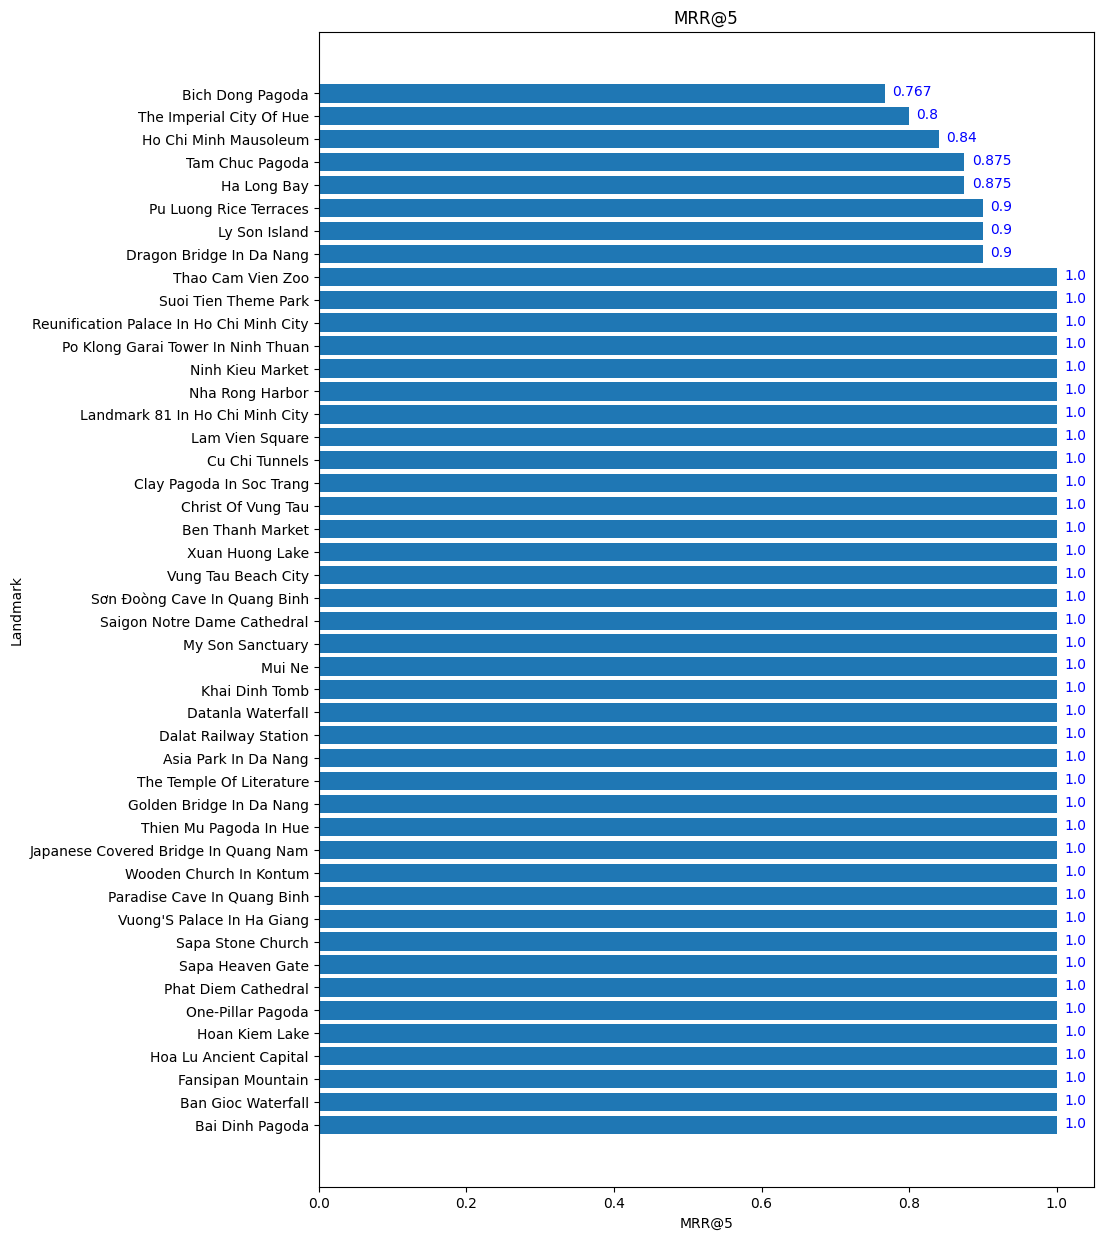

In [42]:
mrr_by_landmark = dict(
    sorted(mrr_by_landmark.items(), key=lambda x: x[1], reverse=True)
)

folder_names = [deserialize_str(lm) for lm in list(mrr_by_landmark.keys())]
scores = list(mrr_by_landmark.values())

plt.figure(figsize=(10, 15))
plt.barh(folder_names, scores)
plt.xlabel(f"MRR@{k}")
plt.ylabel("Landmark")
plt.title(f"MRR@{k}")

for i, v in enumerate(scores):
    plt.text(v + 0.01, i - 0.1, str(round(v, 3)), color="blue")

plt.show()

In [43]:
k_list = [1, 3, 5, 10, 20, 50]
mrrk_scores = [mrrk(answer_list, qlandmark_list, k)[0] for k in k_list]
data = {"Score": mrrk_scores}

df = pd.DataFrame(data, index=[f"mrr@{k}" for k in k_list])

df.round(4)

,Score
mrr@1,0.9261
mrr@3,0.9449
mrr@5,0.9458
mrr@10,0.9481
mrr@20,0.9485
mrr@50,0.9486


# Evaluation summary

In [44]:
avg_rprec = np.array(r_precision_scores).mean()

f"Avg R-Precision: {avg_rprec:.4f}"

'Avg R-Precision: 0.3759'

In [45]:
df = pd.DataFrame(
    {
        "Precision": prec_scores,
        "Recall": recall_scores,
        "mAP": mapk_scores,
        "MRR": mrrk_scores,
    },
    index=[f"@{k}" for k in k_list],
)

df_inverted = df.transpose()

df_inverted.round(4)

,@1,@3,@5,@10,@20,@50
Precision,0.9261,0.8870,0.8400,0.7800,0.7024,0.5763
Recall,0.0065,0.0185,0.0289,0.0531,0.0946,0.1900
mAP,0.9261,0.8734,0.8189,0.7420,0.6444,0.4948
MRR,0.9261,0.9449,0.9458,0.9481,0.9485,0.9486


In [46]:
f"Indexing time: {total_time:.2f} seconds, estimated {total_time / len(ds):.5f} sec/image"

'Indexing time: 67.13 seconds, estimated 0.00759 sec/image'

In [47]:
print(f"Model smmary - ResNet101")
summary(extractor, (3, 224, 224))

Model smmary - ResNet101
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNor